# IMPORTANT:

MLflow grid_search.fit hangs when autolog is turned on and the notebook is ran the very first time. A workaround is to use a small parameter grid first, then use the actual larger parameter grid when you rerun the notebook. It is important that you do not restart the notebook! If you restart the notebook the grid_search.fit call will fail again with a larger parameter grid.

# Data Processing and Model Training - Titanic Dataset

In this notebook we define a proof of concept data processing including both the preprocessing and preparation of the data and the classification model as well. Bundling these two components together allows us to to tune both at the same time to find best fit during the training, and later deploy them as a unit.

### Package imports

The warnings library is used to supress sklearn warning and keep the cell outputs clean. For example some parameters during the hyperparameter training might not be compatible. In these cases sklearn puts out a warning, to tell the user of this issue, but since this doesn't affect the rest of the parameter combinations, and the hyperparameter tuning concludes successfully.

In [1]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

import datetime
import warnings
warnings.filterwarnings("ignore")

In [2]:
import yaml

import matplotlib.pyplot as plt
import mlflow
from mlflow import MlflowClient
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

from src.data.io import load_from_csv
from src.data.io import export_drift_data
from src.model.evaluate import evaluate
from src.model.pipeline import load_config
from src.model.pipeline import load_pipeline
from src.model.pipeline import load_search_params
from src.model import RANDOM_SEED
from src.utils.minio import create_mlflow_bucket
from src.utils.settings import settings

In [3]:
os.environ["AWS_ACCESS_KEY_ID"] = settings.aws_access_key_id
os.environ["AWS_SECRET_ACCESS_KEY"] = settings.aws_secret_access_key
os.environ["MLFLOW_S3_ENDPOINT_URL"] = settings.mlflow_s3_endpoint_url

## MLflow setup

In [4]:
mlflow.set_tracking_uri(uri=settings.mlflow_tracking_url)
mlflow.set_experiment(experiment_name=settings.mlflow_experiment_name)
mlflow.autolog(
    log_models=False,
)

run_name = f"train_{datetime.datetime.now().strftime("%Y%m%d%H%M%S")}"

2025/09/17 13:32:58 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.


### Cloud storage bucket initiation

In [5]:
create_mlflow_bucket()

2025-09-17 13:32:58,516 [INFO] src.utils.logging: Using existing MLflow bucket


## Data import

In [6]:
X_data, y_data = load_from_csv(
    data_path='../data/titanic.csv',
    config_path="../config/data_config.yaml",
)

X_train, X_drift = train_test_split(
    X_data,
    test_size=settings.test_split_size,
    random_state=RANDOM_SEED,
)
y_train, y_drift = train_test_split(
    y_data,
    test_size=settings.test_split_size,
    random_state=RANDOM_SEED,
)

drift_file_name = export_drift_data(X_drift, y_drift)

2025-09-17 13:32:58,522 [INFO] src.utils.logging: Importing data from local csv: ../data/titanic.csv
2025-09-17 13:32:58,528 [INFO] src.utils.logging: Imported dataset (891, 11)
2025-09-17 13:32:58,537 [INFO] src.utils.logging: Using existing MLflow bucket


## Training

For the training we are using grid search hyperparameter tuning with stratified K-fold crossvalidation.

Dummy run. Workaround for the autolog getting stuck on large search grids issue.

In [7]:
config = load_config('../config/pipeline_config_dummy.yaml')
pipeline_config = config.get("pipeline")
search_params_config = config.get("search_parameters", [])

pipeline = load_pipeline(pipeline_config)
search_params = load_search_params(search_params_config)

with mlflow.start_run(
    run_name=run_name,
    log_system_metrics=False,
    tags={"drift-data": drift_file_name},
) as active_run:    
    skf = StratifiedKFold(n_splits=5, shuffle=False)
    grid_search = GridSearchCV(estimator=pipeline, param_grid=search_params, scoring="accuracy", cv=skf, verbose=1)

    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_

    model_info = mlflow.sklearn.log_model(
        sk_model=best_model,
        name=settings.mlflow_model_name,
        input_example=X_train.head(),
        registered_model_name=settings.mlflow_registered_model_name,
    )

    mlflow_client = MlflowClient()
    latest_versions = mlflow_client.get_latest_versions(
        name=settings.mlflow_registered_model_name,
        stages=["None"]
    )

    version_info = next(
        v for v in latest_versions if v.run_id == active_run.info.run_id
    )
    
    # registered model tags
    mlflow_client.set_model_version_tag(
        name=settings.mlflow_registered_model_name,
        version=version_info.version,
        key="drift-data",
        value=drift_file_name,
    )
    mlflow_client.set_model_version_tag(
        name=settings.mlflow_registered_model_name,
        version=version_info.version,
        key="stage",
        value="archived",
    )

Fitting 5 folds for each of 16 candidates, totalling 80 fits


2025/09/17 13:33:00 INFO mlflow.bedrock: Enabled auto-tracing for Bedrock. Note that MLflow can only trace boto3 service clients that are created after this call. If you have already created one, please recreate the client by calling `boto3.client`.
2025/09/17 13:33:00 INFO mlflow.tracking.fluent: Autologging successfully enabled for boto3.
2025/09/17 13:33:01 INFO mlflow.sklearn.utils: Logging the 5 best runs, 11 runs will be omitted.


🏃 View run serious-panda-9 at: http://127.0.0.1:8080/#/experiments/1/runs/7dc74617eb9b46658ee168ffc6f7efc2
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/1
🏃 View run rebellious-loon-669 at: http://127.0.0.1:8080/#/experiments/1/runs/93ca5df5b70046adb3bba2227d78c56a
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/1
🏃 View run luminous-yak-850 at: http://127.0.0.1:8080/#/experiments/1/runs/2edd9c2b14414825b0a8ed8f9ed677b2
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/1
🏃 View run industrious-mare-150 at: http://127.0.0.1:8080/#/experiments/1/runs/67654cb147354e1ab1f8fd8ba9a0ebb8
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/1
🏃 View run hilarious-deer-34 at: http://127.0.0.1:8080/#/experiments/1/runs/28a460acf80149e8be09a11588215288
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/1


Registered model 'sklearn-logreg-model' already exists. Creating a new version of this model...
2025/09/17 13:33:05 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: sklearn-logreg-model, version 16
Created version '16' of model 'sklearn-logreg-model'.


🏃 View run train_20250917133258 at: http://127.0.0.1:8080/#/experiments/1/runs/ac5ac4e9da014450a3a349db182e6f84
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/1


🏃 View run sassy-worm-472 at: http://127.0.0.1:8080/#/experiments/1/runs/b145a16749994dd0bcbfa9191505f905
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/1
🏃 View run bouncy-ape-269 at: http://127.0.0.1:8080/#/experiments/1/runs/acde892a7f8943d4921221bb98a5181b
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/1
🏃 View run honorable-robin-98 at: http://127.0.0.1:8080/#/experiments/1/runs/8ba7fa914c8a4aa689694ad95ab7c062
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/1
🏃 View run blushing-goose-730 at: http://127.0.0.1:8080/#/experiments/1/runs/aa955d6c89bd4cf6a3748176900bab17
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/1
🏃 View run peaceful-loon-26 at: http://127.0.0.1:8080/#/experiments/1/runs/95db401949e942b1acdc9845d56ff821
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/1


Real training run

In [8]:
config = load_config('../config/pipeline_config_dummy.yaml')
pipeline_config = config.get("pipeline")
search_params_config = config.get("search_parameters", [])

pipeline = load_pipeline(pipeline_config)
search_params = load_search_params(search_params_config)

print(pipeline)
for param in search_params:
    print(param)

Pipeline(steps=[('data_pipe',
                 Pipeline(steps=[('preprocessor',
                                  ColumnTransformer(transformers=[('num',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer(strategy='most_frequent')),
                                                                                   ('scaler',
                                                                                    StandardScaler())]),
                                                                   ['Age',
                                                                    'SibSp',
                                                                    'Parch',
                                                                    'Fare']),
                                                                  ('cat',
                                             

In [9]:
RUN_ID = None

with mlflow.start_run(
    run_name=run_name,
    log_system_metrics=False,
    tags={"drift-data": drift_file_name},
) as active_run:
    RUN_ID = active_run.info.run_id
    skf = StratifiedKFold(n_splits=5, shuffle=False)
    grid_search = GridSearchCV(estimator=pipeline, param_grid=search_params, scoring="accuracy", cv=skf, verbose=1)

    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_

    model_info = mlflow.sklearn.log_model(
        sk_model=best_model,
        name=settings.mlflow_model_name,
        input_example=X_train.head(),
        registered_model_name=settings.mlflow_registered_model_name,
    )

    mlflow_client = MlflowClient()
    latest_versions = mlflow_client.get_latest_versions(
        name=settings.mlflow_registered_model_name,
        stages=["None"]
    )

    version_info = next(
        v for v in latest_versions if v.run_id == RUN_ID
    )
    
    # registered model tags
    mlflow_client.set_model_version_tag(
        name=settings.mlflow_registered_model_name,
        version=version_info.version,
        key="drift-data",
        value=drift_file_name,
    )
    mlflow_client.set_model_version_tag(
        name=settings.mlflow_registered_model_name,
        version=version_info.version,
        key="stage",
        value="staging",
    )

Fitting 5 folds for each of 16 candidates, totalling 80 fits


2025/09/17 13:33:08 INFO mlflow.sklearn.utils: Logging the 5 best runs, 11 runs will be omitted.
Registered model 'sklearn-logreg-model' already exists. Creating a new version of this model...
2025/09/17 13:33:12 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: sklearn-logreg-model, version 17
Created version '17' of model 'sklearn-logreg-model'.


🏃 View run train_20250917133258 at: http://127.0.0.1:8080/#/experiments/1/runs/e8a0092da3874439b693087a16f8db35
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/1


In [10]:
test_results = evaluate(
    model_name=settings.mlflow_registered_model_name,
    model_version=version_info.version,
    data_config_path='../config/data_config.yaml',
    test_data_path="../data/titanic_test.csv",
    run_id=RUN_ID,
    run_name=run_name,
)

2025/09/17 13:33:12 INFO mlflow.bedrock: Enabled auto-tracing for Bedrock. Note that MLflow can only trace boto3 service clients that are created after this call. If you have already created one, please recreate the client by calling `boto3.client`.
2025/09/17 13:33:12 INFO mlflow.tracking.fluent: Autologging successfully enabled for boto3.
2025/09/17 13:33:12 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.


2025-09-17 13:33:12,943 [INFO] src.utils.logging: Evaluating model (sklearn-logreg-model:17)


2025/09/17 13:33:13 INFO mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics. Set logger level to DEBUG for more details.
2025/09/17 13:33:13 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.


2025-09-17 13:33:13,303 [INFO] src.utils.logging: {'0': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 266.0}, '1': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 152.0}, 'accuracy': 1.0, 'macro avg': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 418.0}, 'weighted avg': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 418.0}}


2025/09/17 13:33:14 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2025/09/17 13:33:14 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!


🏃 View run train_20250917133258 at: http://127.0.0.1:8080/#/experiments/1/runs/e8a0092da3874439b693087a16f8db35
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/1


The best parameters and the accuracy score of the model:

In [11]:
print("Best Parameters found:\n")
for k, v in grid_search.best_params_.items():
    print(f"{k}: {v}")
print("")
print("Best Cross-Validation Score:", grid_search.best_score_)

Best Parameters found:

classifier: LogisticRegression()
classifier__C: 0.1
classifier__solver: lbfgs
data_pipe__feature_selector__k: 1
data_pipe__preprocessor__cat__imputer__strategy: most_frequent
data_pipe__preprocessor__num__imputer__strategy: mean
data_pipe__preprocessor__num__scaler: None

Best Cross-Validation Score: 0.7840139751552795


# Evaluation

You can see the best fitted model parameters above. This classifier reached a training accuracy of ~78.68%.

This model chose to only 'Sex_female' column, which is created from the 'Sex' column using one-hot encoding.

On the test set this lucky choice results in 100% accuracy, but only because in the training set all female passengers survive and all males die.

In [12]:
for key, value in test_results.items():
    print(f"{key:10} - {value}")

accuracy   - 1.0
precision  - 1.0
recall     - 1.0
f1-score   - 1.0


In [13]:
with open('../config/data_config.yaml', 'r') as file:
    metadata = yaml.safe_load(file)

index_columns = metadata['index_columns']
target_column = metadata['target_column']

df_test = pd.read_csv('../data/titanic_test.csv', index_col=index_columns)
X_test = df_test.drop(columns=target_column)
y_test = df_test[target_column]

y_pred = best_model.predict(X_test)

print("Accuracy of the model on the test dataset:", accuracy_score(y_test, y_pred))

Accuracy of the model on the test dataset: 1.0


In [14]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       266
           1       1.00      1.00      1.00       152

    accuracy                           1.00       418
   macro avg       1.00      1.00      1.00       418
weighted avg       1.00      1.00      1.00       418



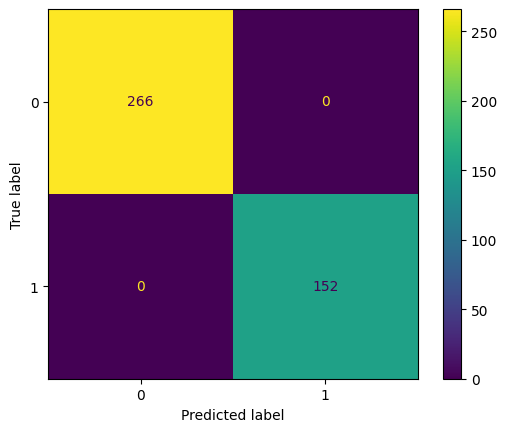

In [15]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()